In [1]:
import visual_behavior.database as db
import visual_behavior.utilities as vbu
from visual_behavior.data_access import loading
from visual_behavior.translator.foraging2 import data_to_change_detection_core
import seaborn as sns
from scipy import signal
from scipy.signal import medfilt

import allensdk.brain_observatory.behavior.running_processing as rp

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%widescreen
%matplotlib notebook

In [3]:
cache = loading.get_visual_behavior_cache()
behavior_session_table = cache.get_behavior_session_table()

In [4]:
loading.get_session_plots_dir.equipment_name.unique()

AttributeError: 'function' object has no attribute 'equipment_name'

In [6]:
conn = db.Database('visual_behavior_data')
collection = conn['behavior_analysis']['running_data_summary']
encoder_summary = pd.DataFrame(list(collection.find({}))).query('std < 2.5')
conn.close()
len(encoder_summary)

9948

In [7]:
encoder_summary[
    encoder_summary['equipment_name']=="CAM2P.4"
][['std','behavior_session_id']]

,std,behavior_session_id
1,0.384414,867036297
4,0.953701,883696092
10,1.603885,822447169
11,0.995524,868743660
27,1.213466,968564134
...,...,...
9849,1.786070,817925173
9855,1.973172,888301437
9859,0.353384,777200179
9881,0.651537,994882261


In [8]:
fig,ax=plt.subplots()
ax.hist(encoder_summary['std'],bins=np.arange(0,2.5,0.1),density=True)
# ax.hist(df.query('equipment_name == "CAM2P.4"')['std'],bins=np.arange(0,2.5,0.1),density=True,alpha=0.5)

<IPython.core.display.Javascript object>

(array([0.20512821, 0.44042232, 1.57968829, 1.86023127, 1.13826043,
        0.75314228, 0.71191554, 0.68476621, 0.58622423, 0.50276521,
        0.44746104, 0.33081951, 0.22926094, 0.13373555, 0.11664153,
        0.0693816 , 0.0563097 , 0.04725993, 0.02916038, 0.02513826,
        0.01709402, 0.02212167, 0.0100553 , 0.00301659]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4]),
 <a list of 24 Patch objects>)

In [9]:
encoder_summary.groupby('equipment_name')['std'].median().sort_values()

equipment_name
BEH.D      0.278380
WF.1       0.288426
BEH.G      0.350271
BEH.E      0.397137
BEH.F      0.427715
NP.1       0.468448
BEH.B      0.468833
MESO.1     0.540074
NP.0       0.640234
CAM2P.3    0.721267
NP.3       0.725210
CAM2P.5    0.911803
CAM2P.4    1.185307
Name: std, dtype: float64

In [10]:
order = encoder_summary.groupby('equipment_name')['std'].median().sort_values().index

In [11]:
ax = sns.boxplot(
    data = encoder_summary,
    x='std',
    y='equipment_name',
    order = order,
    color='gray'
)
ax.set_xlabel('std of signal noisiness distribution')

Text(0.5, 0, 'std of signal noisiness distribution')

In [12]:
def load_running_df(bsid):
    print('loading running data for bsid {}'.format(bsid))
    pkl_path = db.get_pkl_path(int(bsid))
    print('pkl_path = {}'.format(pkl_path))
    data = pd.read_pickle(pkl_path)
    core_data = data_to_change_detection_core(data)
    return core_data['running']


def identify_wraps(row,lower_threshold=1.5,upper_threshold=3.5):
    
    if row['v_sig'] < lower_threshold and row['v_sig_last'] > upper_threshold:
        return 1 # positive wrap
    elif row['v_sig'] > upper_threshold and row['v_sig_last'] < lower_threshold:
        return -1 # negative wrap
    else:
        return 0

def calculate_wrap_corrected_diff(row, max_diff = 1):
    if row['wrap_ID'] == 1:
        # unrwap the current value, subtract the last value
        diff = (row['v_sig'] + row['v_in']) - row['v_sig_last']
    elif row['wrap_ID'] == -1:
        # unwrap the last value, subtract it from the current value
        diff = row['v_sig'] - (row['v_sig_last'] + row['v_in'])
    else:
        diff = row['v_sig'] - row['v_sig_last']
        
    if np.abs(diff) > max_diff:
        return row['v_sig_diff_rolling_median']
    else:
        return diff


def clean_voltage_signal(df_in):
    df = df_in.copy()
    df['v_sig_last'] = df['v_sig'].shift()
    df['v_sig_diff'] = df['v_sig'] - df['v_sig_last']
    df['v_sig_diff_last'] = df['v_sig_diff'].shift()
    df['v_sig_diff_rolling_median'] = df['v_sig_diff'].rolling(window=5,min_periods=0,center=True).median()
    
    # this takes ~1.5 seconds
    df['wrap_ID'] = df.apply(identify_wraps,axis=1)
    
    df['dx_drop_wraps'] = df['dx']
    df.loc[df[df['wrap_ID'] != 0].index,'dx_drop_wraps'] = np.nan
    
    df['v_sig_diff_uncorrected'] = df['v_sig'] - df['v_sig_last']
    
    # this takes ~ 3 seconds
    df['v_sig_diff'] = df.apply(calculate_wrap_corrected_diff,axis=1)
    
    #this should be the equivalent to dx
    df['dx_recalc'] = df['v_sig_diff']/df['v_in']*360

    df['delta_theta'] = df['v_sig_diff']/df['v_in']*2*np.pi
    df['dt'] = df['time'].diff().shift() # the shift is necessary to realign the time
    wheel_diameter = 6.5 * 2.54  # 6.5" wheel diameter
    running_radius = 0.5 * (2.0 * wheel_diameter / 3.0)  # assume the animal runs at 2/3 the distance from the wheel center
    df['speed_cm_s'] = df['delta_theta']/df['dt'] * running_radius
    
    b, a = signal.butter(3, 0.2)
    df['speed_cm_s_filtered'] = signal.filtfilt(b, a, df['speed_cm_s'].fillna(0))
    
    df['dvdt'] = df['v_sig_diff']/df['dt']
    
    return df   

In [13]:
sample = encoder_summary.sample(5,random_state=0)
sample

,_id,count,mean,std,min,25%,50%,75%,max,ophys_session_id,behavior_training_id,equipment_name,date_of_acquisition,donor_id,full_genotype,reporter_line,driver_line,sex,age_in_days,foraging_id,session_type,behavior_session_id,entry_time_utc
5773,5ef1a438ca9483af320f28e1,269766.0,0.000081,0.288911,-4.185885,-0.162804,-0.000052,0.162550,5.490094,NaN,NaN,BEH.G,2019-07-10 12:28:48.524,847864085,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,[Ai94(TITL-GCaMP6s)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",M,134.0,1aaf319a-69a5-4a57-86ca-10d720ccf7a5,TRAINING_5_images_A_epilogue,902975510,2020-06-23 06:42:00.635527
9585,5ef226441ed406d2d80f80b6,269687.0,-0.000026,0.503480,-3.314836,-0.293294,0.022854,0.332243,2.623461,NaN,NaN,CAM2P.4,2019-05-23 08:47:55.165,831004160,Slc6a4-CreERT2_EZ13/wt;Ai162(TIT2L-GC6s-ICL-tT...,[Ai162(TIT2L-GC6s-ICL-tTA2)],[Slc6a4-CreERT2_EZ13],F,147.0,f085c3ae-23c6-4283-a1e8-aa6434f9323c,OPHYS_0_images_A_habituation,874295492,2020-06-23 15:56:52.192436
6792,5ef1a8bd81474005986b57bc,266029.0,-0.000468,1.681518,-9.557811,-0.464611,0.241912,1.255634,6.839878,879719132.0,NaN,CAM2P.3,2019-06-03 08:45:50.517,830940312,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,[Ai94(TITL-GCaMP6s)],"[Camk2a-tTA, Slc17a7-IRES2-Cre]",M,134.0,4bb8a3bc-7380-451d-bd38-49acd86066ca,OPHYS_4_images_B,879846624,2020-06-23 07:01:17.548191
5675,5ef1a38ecf1046184b2fa5da,267829.0,0.000062,0.669607,-33.142789,-0.440420,-0.061941,0.340067,35.881627,NaN,NaN,BEH.F,2019-12-06 08:48:18.058,958769021,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Vip-IRES-Cre],F,124.0,0c2e732e-324d-4e64-b4a3-e0ad7b6bc55a,TRAINING_5_images_G_handoff_ready,992720453,2020-06-23 06:39:10.278149
6086,5ef1a60c908df7594d1d3150,217660.0,-0.000025,0.567260,-7.958695,-0.317356,-0.023331,0.262197,9.111066,NaN,NaN,BEH.B,2019-04-01 13:18:02.710,823836016,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Ai148(TIT2L-GC6f-ICL-tTA2)],[Vip-IRES-Cre],M,81.0,314e1558-32d5-4952-985d-e0a174a21b14,TRAINING_1_gratings,844230822,2020-06-23 06:49:48.732297


In [14]:
data = {}
for idx,row in sample.iterrows():
    bsid = row['behavior_session_id']
    print('on {}'.format(bsid))
    data[bsid]= clean_voltage_signal(load_running_df(bsid))

on 902975510
loading running data for bsid 902975510
pkl_path = /allen/programs/braintv/production/visualbehavior/prod0/specimen_847864095/behavior_session_902975510/190710122843_457766_1aaf319a-69a5-4a57-86ca-10d720ccf7a5.pkl
on 874295492
loading running data for bsid 874295492
pkl_path = /allen/programs/braintv/production/visualbehavior/prod1/specimen_831004180/behavior_session_874295492/190523084746_443737_f085c3ae-23c6-4283-a1e8-aa6434f9323c.pkl
on 879846624
loading running data for bsid 879846624
pkl_path = /allen/programs/braintv/production/visualbehavior/prod0/specimen_830940327/behavior_session_879846624/879719132.pkl
on 992720453
loading running data for bsid 992720453
pkl_path = /allen/programs/braintv/production/visualbehavior/prod3/specimen_958769031/behavior_session_992720453/191206084812_489065_0c2e732e-324d-4e64-b4a3-e0ad7b6bc55a.pkl
on 844230822
loading running data for bsid 844230822
pkl_path = /allen/programs/braintv/production/neuralcoding/prod0/specimen_823836023/be

In [15]:
bsid = 852440775
data.update({
    bsid:clean_voltage_signal(load_running_df(bsid))
})

loading running data for bsid 852440775
pkl_path = /allen/programs/braintv/production/visualbehavior/prod0/specimen_803258386/behavior_session_852440775/852324929.pkl


In [59]:
def make_plot(df,kernel_size=5):
    

    fig,ax=plt.subplots(4,1,sharex=True,figsize=(15,15))

    ax[0].plot(
        df['time'][1:],
        np.diff(df['time']),
        '.-k'
    )
    ax[0].set_ylabel('delta t (s)')
    ax[0].set_title('dt')
    # ax[0].set_ylim(0.015,0.018)

    ax[1].plot(
        df['time'],
        df['v_sig'],
        '.-'
    )
    ax[1].plot(
        df['time'],
        df['v_in'],
        '.-'
    )
    ax[1].set_ylim(-0.5,5.5)
    ax[1].set_ylabel('V')
    ax[1].set_title('voltage signals')
    ax[1].legend(['v_sig','v_in'])

    ax[2].plot(
        df['time'],
        df['dx_recalc'],
        color='gray',
        alpha=0.5
    )
    
    ax[2].plot(
        df['time'],
        medfilt(df['dx_recalc'], kernel_size=5),
        '--',
        color='blue'
    )

    ax[2].plot(
        df['time'],
        df['dx'],
        '-r'
    )
    
    ax[2].plot(
        df['time'],
        medfilt(df['dx'], kernel_size=5),
        '.-k',
    )
    
    ax[2].plot(
        df['time'],
        medfilt(df['dx'], kernel_size=kernel_size),
        color='orange',
        alpha=0.95
    )

    # rolling_mean = df['dx'].rolling(window=10,center=True, min_periods=0).mean()
    # ax[2].plot(
    #     df['time'],
    #     rolling_mean,
    #     color='blue',
    #     alpha=0.95
    # )

    ax[2].set_ylabel('deg/s')
    ax[2].set_title('dx (should be called d_theta)')
    ax[2].set_ylim(-2,15)
    ax[2].legend(['raw_recalculated','median filtered recalculated','raw','current 5 element median filter','median_filtered (kernel_size = {})'.format(kernel_size)])

    
    df['speed_raw'] = rp.deg_to_dist(rp.calc_deriv(
        np.cumsum(df['dx']),
        df['time'],
    ))
    
    
    df['speed_new'] = rp.deg_to_dist(rp.calc_deriv(
        np.cumsum(df['dx_drop_wraps'].rolling(window=kernel_size,center=True,min_periods=0).median()),
        df['time'],
    ))
    
    
    ax[3].plot(
        df['time'],
        df['speed_raw'],
        '-r'
    )

    ax[3].plot(
        df['time'],
        df['speed'],
        '.-k'
    )

    ax[3].plot(
        df['time'],
        df['speed_new'],
        '-',
        color='orange'
    )
    
#     ax[3].set_ylim(-10,100)
    ax[3].legend(['from raw dx','current 5-element median filter', '{}-element centered median filter'.format(kernel_size)],loc='upper left')

    ax[3].set_ylabel('speed (cm/s)')
    ax[3].set_title('computed running speed')

    # ax[-1].set_xlim(889.25,892)

    ax[-1].set_xlabel('time (s)')
    fig.tight_layout()
    
    return fig,ax

<IPython.core.display.Javascript object>


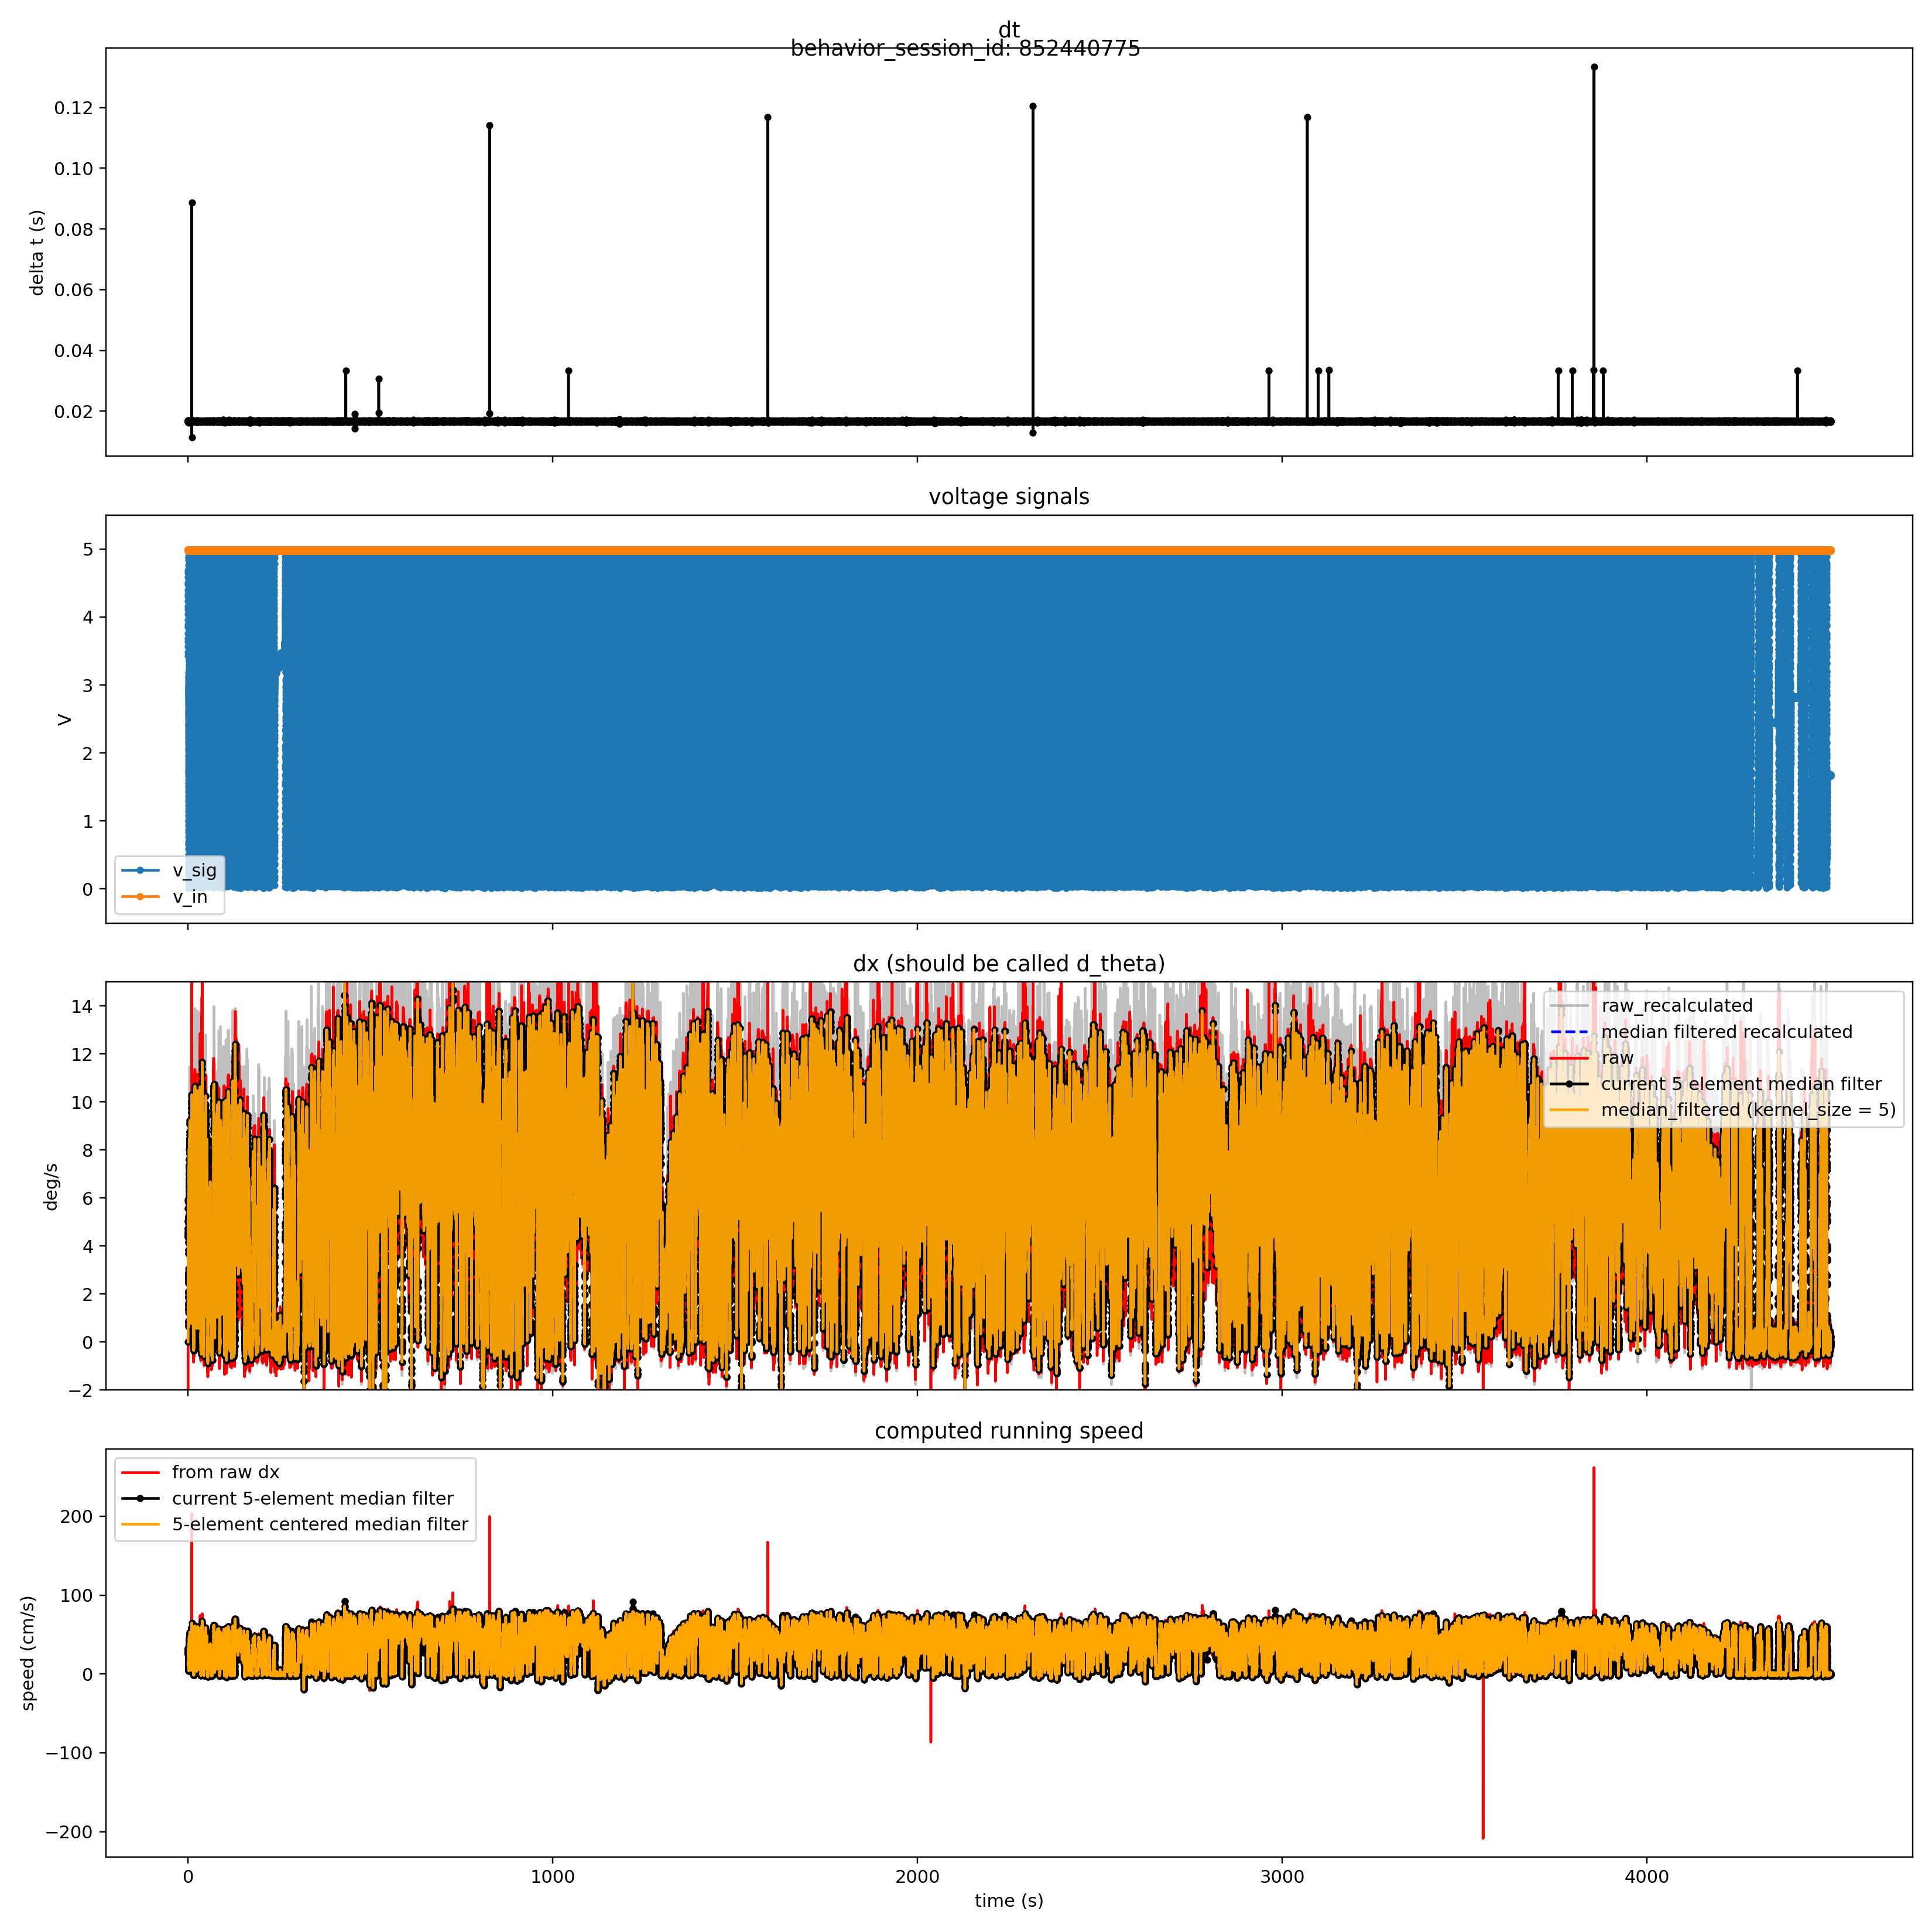

Text(0.5, 0.98, 'behavior_session_id: 852440775')

In [60]:
bsid = 852440775
fig,ax=make_plot(data[bsid],kernel_size=5)
fig.suptitle('behavior_session_id: {}'.format(bsid,))
# ax[3].set_xlim(2921,2931)

## notes
* every time the encoder wraps, camstim is replacing dx with its previous value. Because the noise is regular and oscillatory, this sometimes breaks the oscillatory pattern.
* I can recalculate dx from the raw encoder values with reasonable accuracy everywhere but at the encoder wraps. My understanding of the encoder is that the max voltage that v_sig could acheive is set by v_in. So as v_sig should have to cross v_in before returning to 0, but v_in appears to be an over-estimate of the max value, which explains the sudden spike in recalculated dx at the wrap.

In [18]:
data[bsid].query('time > 2924.25 and time < 2924.5')

,time,frame,speed,dx,v_sig,v_in,v_sig_last,v_sig_diff,v_sig_diff_last,v_sig_diff_rolling_median,wrap_ID,dx_drop_wraps,v_sig_diff_uncorrected,dx_recalc,delta_theta,dt,speed_cm_s,speed_cm_s_filtered,dvdt,speed_raw,speed_new
175284,2924.259403,175284,51.628171,9.369323,4.155164,4.978186,4.035005,0.120159,0.071062,0.120159,0,9.369323,0.120159,8.689328,0.151657,0.016693,49.998830,44.200520,7.198222,54.175220,51.628171
175285,2924.276125,175285,49.837638,9.423796,4.284367,4.976894,4.155164,0.129203,0.120159,0.116282,0,9.423796,0.129203,9.345789,0.163115,0.016632,53.972900,43.359536,7.768343,38.261694,49.837638
175286,2924.292805,175286,49.936924,3.858344,4.348968,4.989814,4.284367,0.064601,0.129203,0.120159,0,3.858344,0.064601,4.660795,0.081346,0.016722,26.771526,42.435940,3.863241,35.848058,49.936924
175287,2924.309460,175287,47.546723,8.556350,4.465251,4.987230,4.348968,0.116282,0.064601,0.116282,0,8.556350,0.116282,8.393777,0.146499,0.016680,48.336341,41.493611,6.971520,49.848442,47.546723
175288,2924.326163,175288,45.762579,8.774323,4.587993,4.988522,4.465251,0.122743,0.116282,0.116282,0,8.774323,0.122743,8.857803,0.154598,0.016655,51.084642,40.630026,7.369814,36.665959,45.762579
175289,2924.342856,175289,44.891983,3.983504,4.638382,4.983354,4.587993,0.050389,0.122743,0.116282,0,3.983504,0.050389,3.640133,0.063532,0.016704,20.931933,39.939300,3.016653,34.364319,44.891983
175290,2924.359534,175290,33.470551,7.955615,4.754665,4.989814,4.638382,0.116282,0.050389,0.104654,0,7.955615,0.116282,8.389430,0.146423,0.016693,48.274052,39.448207,6.966143,44.806415,38.735459
175291,2924.376217,175291,30.292630,7.641289,4.859319,4.988522,4.754665,0.104654,0.116282,0.050389,0,7.641289,0.104654,7.552443,0.131815,0.016678,43.494491,39.051435,6.274808,31.126384,37.143604
175292,2924.392900,175292,28.248058,3.165376,4.899372,4.984646,4.859319,0.040053,0.104654,0.090442,0,3.165376,0.040053,2.892689,0.050487,0.016683,16.654602,38.518325,2.400838,18.370192,34.553941
175293,2924.409550,175293,18.813133,3.165376,0.062020,4.989814,4.899372,0.152462,0.040053,0.045221,1,NaN,-4.837352,10.999696,0.191981,0.016683,63.330547,37.591189,9.138857,28.057823,27.959773


In [19]:
data[bsid].query('time > 2924.25 and time < 2924.5')[['time','v_sig','v_in','v_sig_diff','wrap_ID']]

,time,v_sig,v_in,v_sig_diff,wrap_ID
175284,2924.259403,4.155164,4.978186,0.120159,0
175285,2924.276125,4.284367,4.976894,0.129203,0
175286,2924.292805,4.348968,4.989814,0.064601,0
175287,2924.309460,4.465251,4.987230,0.116282,0
175288,2924.326163,4.587993,4.988522,0.122743,0
175289,2924.342856,4.638382,4.983354,0.050389,0
175290,2924.359534,4.754665,4.989814,0.116282,0
175291,2924.376217,4.859319,4.988522,0.104654,0
175292,2924.392900,4.899372,4.984646,0.040053,0
175293,2924.409550,0.062020,4.989814,0.152462,1


In [22]:
experiment_id = db.lims_query('select id from ophys_experiments where ophys_session_id = {}'.format(int(behavior_session_table.loc[bsid]['ophys_session_id'])))
experiment_id

852689577

In [23]:
session = loading.get_ophys_dataset(experiment_id)

In [24]:
running_df = session.running_data_df
running_df_cleaned = clean_voltage_signal(running_df.reset_index().rename(columns={'timestamps':'time'}))

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


In [33]:
session.trials

,lick_times,reward_time,reward_volume,hit,false_alarm,miss,stimulus_change,aborted,go,catch,auto_rewarded,correct_reject,start_time,stop_time,trial_length,response_time,change_frame,change_time,response_latency,initial_image_name,change_image_name,epoch,trial_type
trials_id,,,,,,,,,,,,,,,,,,,,,,,
0,[314.85998439091196],311.943493,0.005,False,False,False,True,False,False,False,True,False,307.290577,316.047667,8.757090,NaN,18252.0,311.845203,3.014781,im000,im106,0,auto_rewarded
1,[323.917350281552],320.200597,0.005,False,False,False,True,False,False,False,True,False,316.297137,324.303779,8.006642,NaN,18747.0,320.101983,3.815367,im106,im031,0,auto_rewarded
2,[325.0682849580489],NaN,0.000,False,False,False,False,True,False,False,False,False,324.553999,325.371180,0.817181,NaN,NaN,NaN,NaN,im031,im031,0,None
3,"[326.1525210864456, 326.3026194430972, 326.469...",NaN,0.000,False,False,False,False,True,False,False,False,False,326.055191,328.807288,2.752097,NaN,NaN,NaN,NaN,im031,im031,0,None
4,"[329.255052123158, 329.4218450111224, 329.7220...",NaN,0.000,False,False,False,False,True,False,False,False,False,329.058181,330.025422,0.967241,NaN,NaN,NaN,NaN,im031,im031,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,"[3882.50423036306, 3882.6376701737604, 3882.98...",3882.499696,0.007,True,False,False,True,False,True,False,False,False,3878.086739,3886.110583,8.023844,3882.499662,232240.0,3881.891533,0.612697,im073,im054,5,hit
801,"[3889.14296172703, 3889.4265607474294, 3889.54...",NaN,0.000,False,False,False,False,True,False,False,False,False,3886.343459,3889.846164,3.502705,NaN,NaN,NaN,NaN,im054,im054,5,None
802,"[3897.5164758700657, 3897.683261736695, 3897.8...",NaN,0.000,False,False,False,False,False,False,True,False,True,3890.096479,3898.871056,8.774577,NaN,233004.0,3894.651963,2.864513,im054,im054,5,correct_reject


In [34]:
hit_change_times = session.trials.query('hit')['change_time']
miss_change_times = session.trials.query('miss')['change_time']
cr_change_times = session.trials.query('correct_reject')['change_time']

In [30]:
running_df_cleaned.head()

,time,speed,dx,v_sig,v_in,v_sig_last,v_sig_diff,v_sig_diff_last,v_sig_diff_rolling_median,wrap_ID,dx_drop_wraps,v_sig_diff_uncorrected,dx_recalc,delta_theta,dt,speed_cm_s,speed_cm_s_filtered,dvdt
0,7.314303,25.022575,-47.735771,3.429044,4.989814,NaN,NaN,NaN,0.070416,0,-47.735771,NaN,NaN,NaN,NaN,NaN,-0.027866,NaN
1,7.331083,25.082509,4.371402,3.483310,4.980770,3.429044,0.054265,NaN,0.072354,0,4.371402,0.054265,3.922177,0.068455,NaN,NaN,9.778637,NaN
2,7.347783,28.586295,5.855837,3.569875,4.988522,3.483310,0.086566,0.054265,0.063309,0,5.855837,0.086566,6.247082,0.109032,0.01678,35.759255,18.291844,5.158871
3,7.364463,32.915934,5.562266,3.642229,4.982062,3.569875,0.072354,0.086566,0.072354,0,5.562266,0.072354,5.228213,0.091250,0.01670,30.070452,24.614869,4.332548
4,7.381103,32.964086,2.667241,3.684866,4.989814,3.642229,0.042637,0.072354,0.077522,0,2.667241,0.042637,3.076124,0.053689,0.01668,17.713772,28.471601,2.556170


In [35]:
etr

,time,event_0_t=399.66687307623914,event_1_t=408.6743130762391,event_2_t=419.93339307623916,event_3_t=429.69134307623915,event_4_t=437.94819307623914,event_5_t=446.95542307623913,event_6_t=454.46165307623914,event_7_t=470.97515307623917,event_8_t=482.2344030762391,event_9_t=512.2587130762391,event_10_t=710.4203930762392,event_11_t=861.2934530762392,event_12_t=871.8020430762391,event_13_t=879.3082530762391,event_14_t=907.8314630762392,event_15_t=964.1275030762391,event_16_t=988.8975630762392,event_17_t=996.4036730762391,event_18_t=1014.4185130762392,event_19_t=1127.026963076239,event_20_t=1160.0539230762392,event_21_t=1168.3106330762391,event_22_t=1187.076073076239,event_23_t=1358.2155830762392,event_24_t=1437.7973030762391,event_25_t=1446.053903076239,event_26_t=1453.560023076239,event_27_t=1522.6164230762392,event_28_t=1611.2554730762392,event_29_t=1693.8394030762393,event_30_t=1768.9006530762392,event_31_t=1886.7469530762392,event_32_t=1906.262753076239,event_33_t=1922.0257430762392,event_34_t=1981.323983076239,event_35_t=2049.629733076239,event_36_t=2133.698303076239,event_37_t=2198.250993076239,event_38_t=2220.0188530762393,event_39_t=2253.0458230762392,event_40_t=2260.5518330762393,event_41_t=2323.603283076239,event_42_t=2439.948213076239,event_43_t=2659.877753076239,event_44_t=2732.687053076239,event_45_t=2858.039793076239,event_46_t=2904.577453076239,event_47_t=2924.0932530762393,event_48_t=2963.875723076239,event_49_t=3002.924363076239,event_50_t=3214.597203076239,event_51_t=3234.863473076239,event_52_t=3289.658213076239,event_53_t=3322.685263076239,event_54_t=3330.1912530762393,event_55_t=3374.477393076239,event_56_t=3415.010523076239,event_57_t=3433.7758030762393,event_58_t=3442.7831630762394,event_59_t=3451.0400430762393,event_60_t=3459.2967030762393,event_61_t=3544.1158430762393,event_62_t=3712.253043076239,event_63_t=3728.766503076239,event_64_t=3775.304613076239,event_65_t=3848.113983076239,event_66_t=3881.8915330762393
0,-10.000000,36.716721,38.320987,-0.084292,49.716743,55.895547,61.102123,61.179507,60.207610,-0.035243,46.686155,37.598383,48.842821,6.476049,22.622459,45.856950,63.299309,61.623645,64.619553,32.091362,44.814917,2.780475,43.249346,50.760839,42.100504,32.636694,29.816635,39.643771,49.434532,46.241430,25.803133,59.060026,42.341115,60.883848,33.718416,51.881190,37.901546,35.097471,35.698531,55.127544,24.959634,47.665332,52.356829,41.537681,13.328627,34.685851,34.638451,37.231224,59.835866,40.583527,44.625975,50.299908,39.504821,49.826234,56.305657,53.609258,52.134843,65.026142,0.429845,5.861591,46.535580,42.492860,58.323242,23.420157,7.682110,52.698023,49.275257,2.975958
1,-9.983333,36.725684,38.468093,-0.010760,49.792554,55.952171,60.692713,60.738709,59.935029,0.170464,46.943578,37.186472,48.449877,6.150574,22.635445,45.629403,63.967151,61.500377,64.806905,31.802608,44.856249,3.038645,43.182023,50.827767,41.875701,32.575026,30.057799,40.221708,49.571652,45.755902,26.372240,58.659106,42.788748,60.225217,33.767606,52.181867,37.971713,34.521132,35.636668,55.225667,24.852728,47.775681,52.843902,41.062851,12.993310,35.031927,33.769353,37.240108,59.869802,40.608473,44.762999,50.418581,39.494259,50.042773,56.486678,52.902791,52.118231,64.881671,0.372350,5.663203,46.458103,42.481869,58.213893,23.195901,7.789485,52.803301,49.387547,2.621255
2,-9.966667,36.686580,38.865645,0.179445,49.802832,56.129137,59.947849,59.732790,59.363232,0.544892,47.374816,36.503229,47.782034,5.608747,23.003866,45.207993,65.151791,61.358613,65.311629,31.063708,44.982772,3.472812,43.047925,50.920350,41.310276,32.442542,30.733487,40.940977,49.677937,44.727347,27.520302,57.880467,43.665893,58.996122,33.850379,52.960232,38.146558,33.516596,35.478938,55.416008,24.926486,47.861435,54.033398,40.232249,12.474506,35.515247,32.117329,37.226763,59.925339,40.599883,44.993211,50.555082,39.378474,50.777009,56.793377,51.297787,52.007421,64.266327,0.199406,5.260541,46.013155,42.492735,57.929781,22.608766,8.204701,52.965865,49.453241,1.948037
3,-9.9

In [53]:
def event_triggered_running_response(session, running_df, speed_column, event_type):

    change_times = session.trials.query(event_type)['change_time']
    etr = vbu.event_triggered_response(
        df = running_df,
        parameter = speed_column,
        event_times = change_times
    )
    x_value = 'time'
    y_values = [col for col in etr.columns if col != 'time']
    var_name = 'line'
    value_name = 'value'
    df_melted = pd.melt(
            etr,
            id_vars=[x_value],
            value_vars=y_values,
            var_name='event_name',
            value_name='running_speed'
        )
    df_melted['speed_type'] = speed_column
    df_melted['event_type'] = event_type
    return df_melted

melted_etr = []
for event_type in ['hit','miss','correct_reject']:
    melted_etr.append(event_triggered_running_response(
        session,
        running_df = running_df_cleaned,
        speed_column = 'speed_cm_s_filtered',
        event_type = event_type,
    ))
melted_etr = pd.concat(melted_etr)
melted_etr

,time,event_name,running_speed,speed_type,event_type
0,-10.000000,event_0_t=399.66687307623914,36.716721,speed_cm_s_filtered,hit
1,-9.983333,event_0_t=399.66687307623914,36.725684,speed_cm_s_filtered,hit
2,-9.966667,event_0_t=399.66687307623914,36.686580,speed_cm_s_filtered,hit
3,-9.950000,event_0_t=399.66687307623914,36.501114,speed_cm_s_filtered,hit
4,-9.933333,event_0_t=399.66687307623914,36.098087,speed_cm_s_filtered,hit
...,...,...,...,...,...
28795,9.916667,event_23_t=3894.651963076239,39.384397,speed_cm_s_filtered,correct_reject
28796,9.933333,event_23_t=3894.651963076239,39.259985,speed_cm_s_filtered,correct_reject
28797,9.950000,event_23_t=3894.651963076239,39.144394,speed_cm_s_filtered,correct_reject
28798,9.966667,event_23_t=3894.651963076239,39.068034,speed_cm_s_filtered,correct_reject


<IPython.core.display.Javascript object>


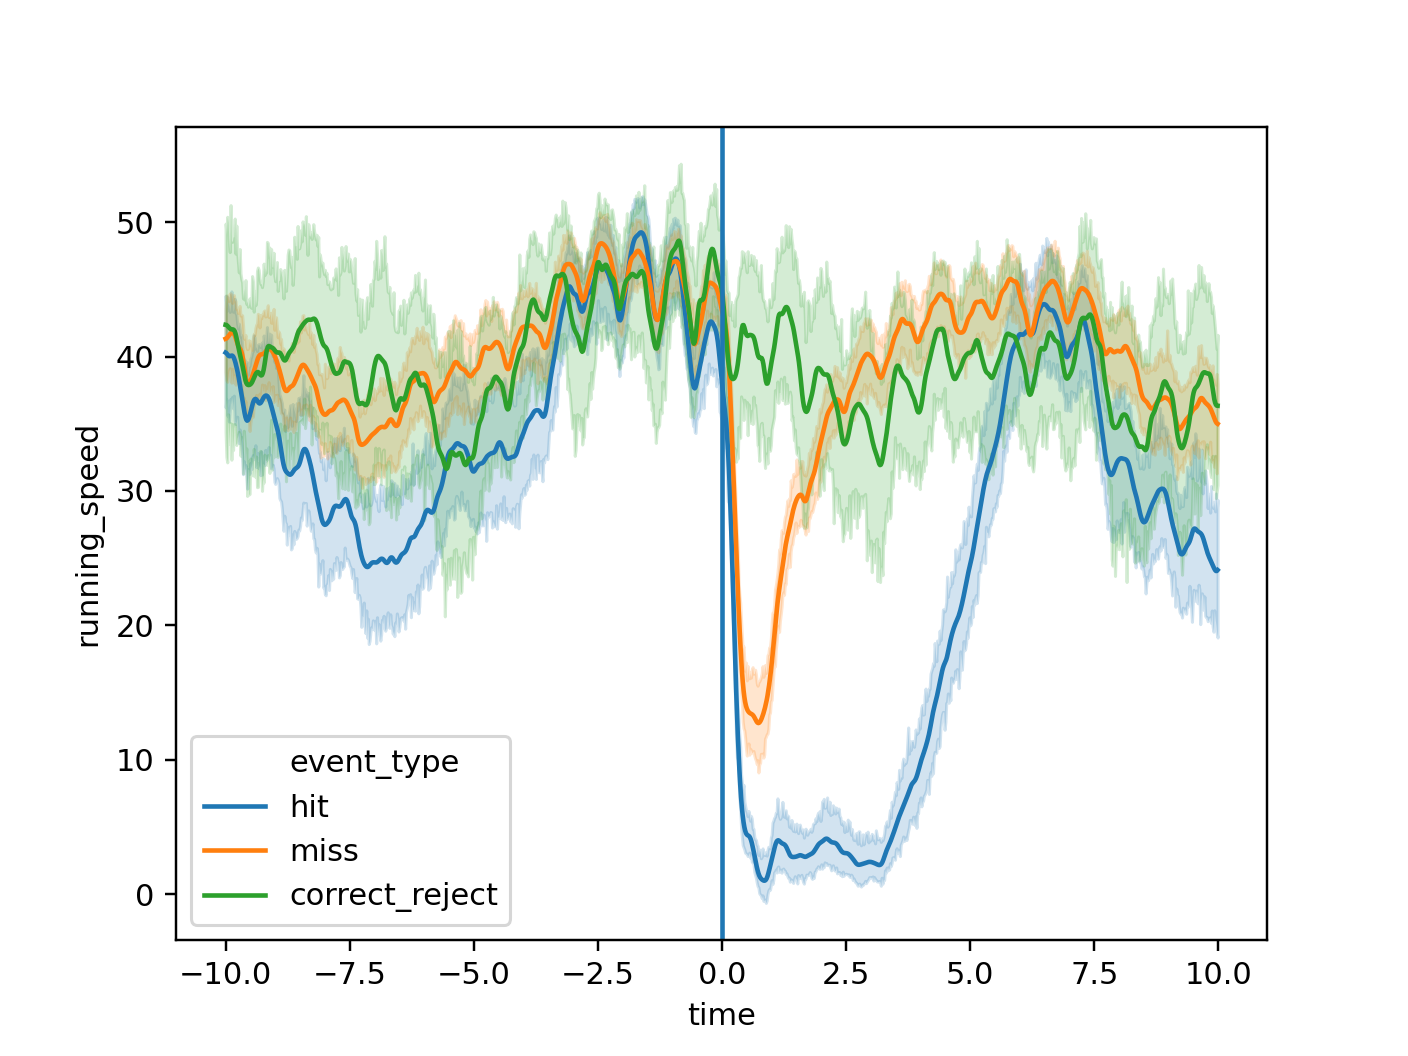

In [54]:
fig,ax=plt.subplots()
sns.lineplot(
    data=melted_etr,
    x='time',
    y='running_speed',
    hue = 'event_type',
    n_boot=100
)
ax.axvline(0)

In [31]:
df_all = []
for speed_col in ['speed','speed_cm_s','speed_cm_s_filtered']:
    print(speed_col)
    etr = vbu.event_triggered_response(
        df = running_df_cleaned,
        parameter = speed_col,
        event_times = hit_change_times
    )
    x_value = 'time'
    y_values = [col for col in etr.columns if col != 'time']
    var_name = 'line'
    value_name = 'value'
    df_melted = pd.melt(
            etr,
            id_vars=[x_value],
            value_vars=y_values,
            var_name='event_name',
            value_name='running_speed'
        )
    df_melted['speed_type'] = speed_col
    df_all.append(df_melted)
df_all = pd.concat(df_all)


speed
speed_cm_s
speed_cm_s_filtered


In [32]:
df_all

,time,event_name,running_speed,speed_type
0,-10.000000,event_0_t=399.66687307623914,39.354760,speed
1,-9.983333,event_0_t=399.66687307623914,40.129705,speed
2,-9.966667,event_0_t=399.66687307623914,40.997163,speed
3,-9.950000,event_0_t=399.66687307623914,40.459207,speed
4,-9.933333,event_0_t=399.66687307623914,40.067000,speed
...,...,...,...,...
80395,9.916667,event_66_t=3881.8915330762393,52.406210,speed_cm_s_filtered
80396,9.933333,event_66_t=3881.8915330762393,52.690259,speed_cm_s_filtered
80397,9.950000,event_66_t=3881.8915330762393,52.908428,speed_cm_s_filtered
80398,9.966667,event_66_t=3881.8915330762393,53.059656,speed_cm_s_filtered


<IPython.core.display.Javascript object>


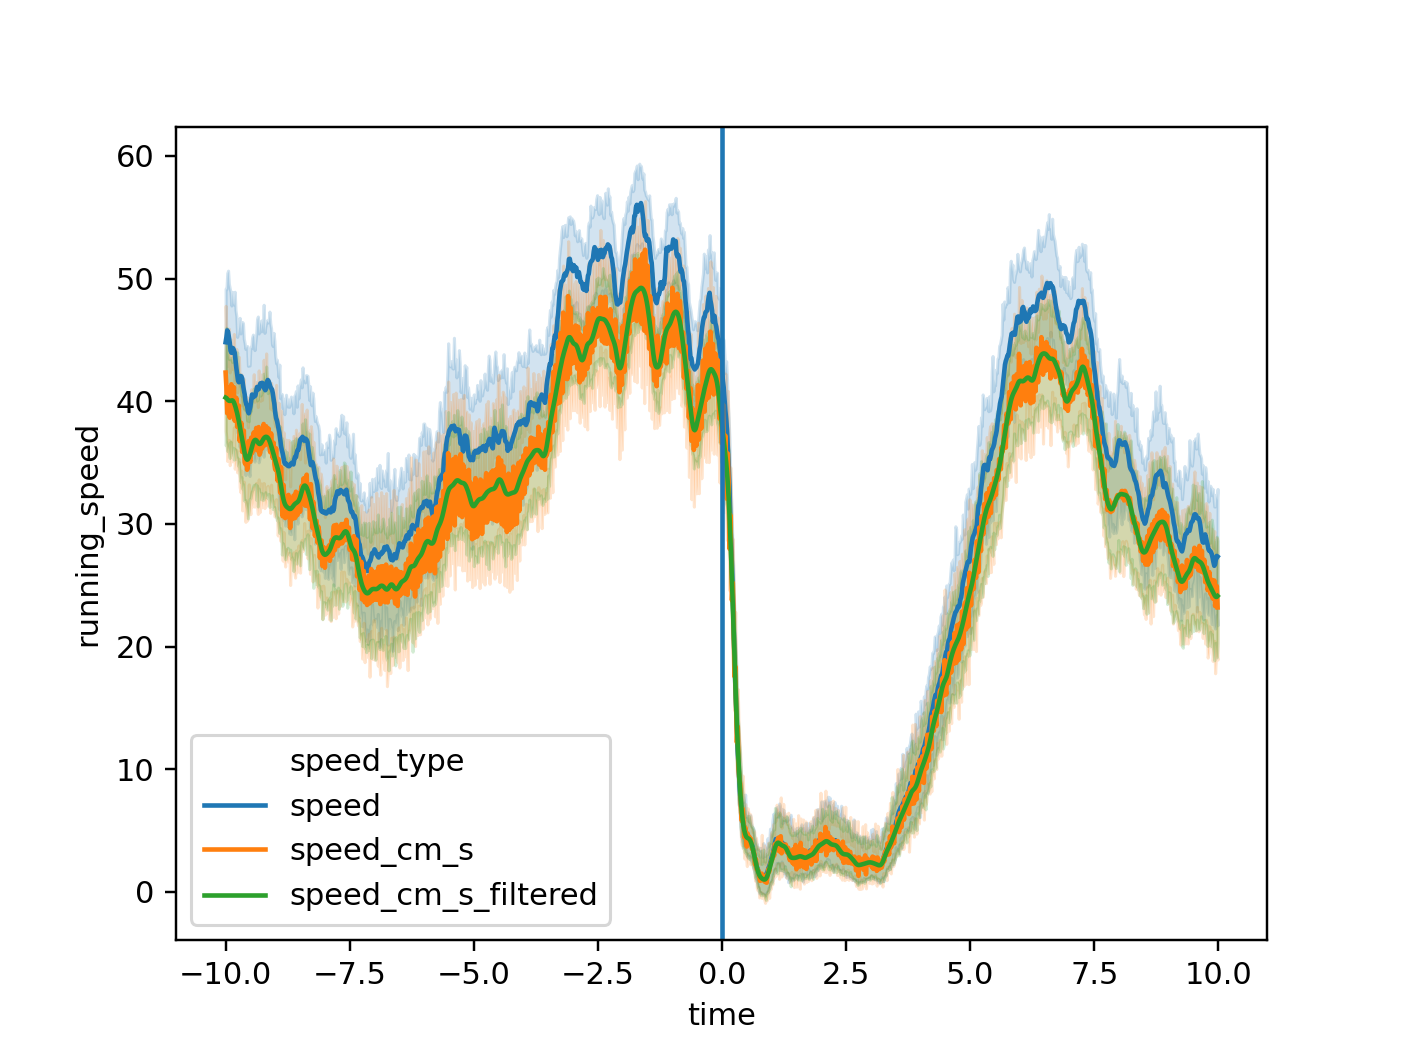

In [29]:
fig,ax=plt.subplots()
sns.lineplot(
    data=df_all,
    x='time',
    y='running_speed',
    hue = 'speed_type',
    n_boot=100
)
ax.axvline(0)